<h1><center>

</center></h1>
<font size="6"><center>
EIE 401
PROCESAMIENTO DIGITAL MULTIMEDIA 
</center></font>


<center><h2>Proyecto 2</h2></center>
<center><h3>Procesamiento digital de señales</h3></center>
<center><h3>Profesor: Jorge Cardenas</h3></center>

<center><h3>Por: Javier Brito Parra</h3></center>
<center><h5>Pontificia Universidad Catolica de Valparaiso</h5></center>
 

In [1]:
from IPython.display import IFrame, display
#filepath = "Proyecto_2_EIE401.pdf"
#IFrame(filepath, width=700, height=400)

En la dirección https://huggingface.co/datasets/astroboy1/metasurfaces_V1_30-90GHZ encontrarás el archivo batch_june2024.zip que contiene las imagenes que usarás para el procesamiento. ATENCION: usa el archivo zip indicado pues tienes las imagenes preparadas para tu trabajo.

## 1. Carga de Datos


- En los archivos, encontrarás un folder con imagenes de 3 categorías: cross, box, circle.
Cada imagen tiene una medida de 512x512 pixeles y 3 canales. Se han acentuado los azules y rojos para facilitar el proceso de obtención de características.

- Puedes extraer la clase a la que pertenece la imagen, desde el nombre del archivo. Ahí mismo encuentras números de serie que te permiten identificar de forma específica una imagen.

- Se te entrega 3 imagenes de referencia de 32x32 pixeles, las que debes usar como plantilla para el proceso de clasificación de la imagen.


In [2]:
import os
import time
import torch
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay

In [3]:
## Funcion de cargar imagen y devolver tensor en PyTorch.
def load_image(image_path, transform=None):
    image = Image.open(image_path).convert('L')## Convertir a escala de grises
    if transform:
        image = transform(image)         ## Aplicar transformacion si se especifica.
    tensor_image = image_to_tensor(image)## Convertir la imagen a tensor
    return tensor_image                  ## Devuelve un tensor

def image_to_tensor(image):
    # Convierte la imagen a un array de numpy, añade una dimensión adicional (para el canal), 
    ## Convierte a tipo float y normaliza los valores dividiéndolos por 255.
    return torch.tensor(np.array(image)).unsqueeze(0).float() / 255.0

## 2. Transformar imagen
Recuerda que la tarea es lograr el procesamiento más rápido posible.
Para lograr esto, realiza las operaciones que consideres necesarias sobre la imagen original para el posterior trabajo de Matching con las plantillas dadas. Crees que trabajar en el dominio de fourier o wavelet ayudaría en las etapas posteriores?

In [4]:
## Transformaciones de imagenes a escala de grises
transform = transforms.Compose([
    transforms.Resize((512, 512)),## Dim(512x512)
    transforms.Grayscale(),       ## Convertir a escala de grises
])
template_transform = transforms.Compose([
    transforms.Resize((16, 16)),## Dim(16x16)
    transforms.Grayscale(),     ## Convertir a escala de grises
])


* Se utiliza la resolución original para que el algoritmo no pierda fidelidad.

In [5]:
## Cargar templates
templates_path = "templates"
templates = {}   ## Se iterara en los 3 templates
for template_name in ["box_templae", "circ_templae", "cross_templae"]:
    template_path = os.path.join(templates_path, f"{template_name}.png")
    templates[template_name] = load_image(template_path, template_transform)

## 3. Operaciones
Para extraer las caracteristicas, debes realizar las operaciones de segmentación, normalización o convolución como creas necesarias.
El resultado de tus operaciones vas a usarlo para el proceso de matching.


* Esta comentado cada proceso por el cual pasan las imagenes para realizar la convolucion normalizada.

In [6]:
def normalized_correlation(image, template):
    template_mean = template.mean()                             ## Media del template.
    template = template - template_mean                         ## Resta del valor de media a cada pixel del template.
    template = template.unsqueeze(0)                            ## Añade una dimensión a la imagen template.
    image_mean = image.mean(dim=(2, 3), keepdim=True)           ## Calculo media imagen original.
    image_std = image.std(dim=(2, 3), keepdim=True)             ##  Calculo desviación estandar imagen original.
    image_normalized = (image - image_mean) / (image_std + 1e-5)## Normaliza la imagen utilizando los
                                                                ## valores de media y desviacion estandar.
                                                                
    template_std = template.std()                               ## Calcula la desviacion estandar de template.
    template_normalized = template / (template_std + 1e-5)      ## Normalizacion template.
    ## Convolucion entre imagenes normalizadas
    norm_conv_result = F.conv2d(image_normalized, template_normalized, padding=0)
    return norm_conv_result.squeeze().numpy()## Devuelve la correlacion normalizada

## 4. Matching
El proceso de matching debe considerar que vas a usar las imagenes de referencia para calcular la correlación

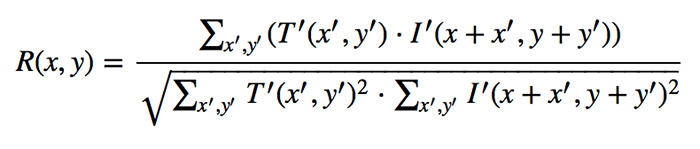

Este proceso es similar a un windowing, donde la ventana es la imagen de referencia. 
Como verás es un proceso iterativo, dispendioso, pero en el que puedes poner tu creatividad a funcionar para lograrlo de forma eficiente.

#### _TIP: realiza el proceso un batch pequeño de imagenes, o solo sobre un par de ellas, hasta que estés satisfecho con el resultado. Una vez esté listo, ESCALA el procedimiento para operar todas la imagenes lo más rápido posible.!_

In [7]:
## Medir el tiempo de procesamiento
start_time = time.time()

# Procesar imágenes y obtener predicciones
processed_path = "processed512" ## Ruta de carpeta con imagenes
results = []
for image_name in os.listdir(processed_path):
    image_path = os.path.join(processed_path, image_name)
    image = load_image(image_path, transform)
    image = image.unsqueeze(0)## Utilizado para añador una dimension para la convolucion.
    scores = {}
    for template_name, template in templates.items():
        correlation_map = normalized_correlation(image, template) ## Llamada a la funcion de correlacion normalizada por cada template.
        scores[template_name] = correlation_map.max()
    label = image_name.split('_')[0]
    results.append((image_name, label, scores))

# 5. Clasificación
De cada operación realizada de matching, obtendrás valores para inferir si la imagen bajo estudio corresponde con alguna de las 3 categorías: cross, box, circle.

Debes almacenar cada resultado obtenido para cada imagen, hallar el error de clasificación y generar un informe del error general al clasificar todas las imagenes.

Presenta aquí el resultado de clasificación numérico, así como  dos ejemplos verdaderos y dos ejemplos falsos de imagenes clasificadas.


* Se utilizo como criterio el valor mayor de la correlacion normalizada.

In [8]:
## Obtener las predicciones
predictions = []
for image_name, label, scores in results:
    predicted_template = max(scores, key=scores.get)## Se busca en el diccionario de "scores" el valor mas alto.
    prediction_score = scores[predicted_template]   ## 
    predictions.append((image_name, label, predicted_template, prediction_score))## Se convierte a un vector de 
                                                                                ## Imagen,etiqueta, etiqueta predecida y puntaje de correlacion.
end_time = time.time()
total_time = end_time - start_time ## Calculo del tiempo utilizado

* Se muestra el vector de prediccion obtenido y etiquetas reales.

In [10]:
print(predictions[0])

('box_01_freq_reflect_09a2f2c2-ad7f-11ee-bb2a-047c16a08772_0-0_80-90.png', 'box', 'box_templae', 867.48083)


In [11]:
print(predictions[1000])

('box_01_freq_reflect_2a1a6b92-ea35-11ee-b922-047c16a08772_0-513_80-90.png', 'box', 'box_templae', 472.2976)


In [12]:
print(predictions[4000])

('circ_01_freq_reflect_536ce6b7-e07b-11ee-9fac-047c16a08772_0-10_80-90.png', 'circ', 'circ_templae', 255.8855)


* Se muestran etiquetas erroneas:

In [13]:
print(predictions[4500])

('circ_01_freq_reflect_56dee422-b317-11ee-bb58-047c16a08772_0-129_80-90.png', 'circ', 'box_templae', 398.48383)


In [14]:
print(predictions[4550])

('circ_01_freq_reflect_56dee422-b317-11ee-bb58-047c16a08772_0-1344_80-90.png', 'circ', 'box_templae', 247.13239)


* Se obtiene la matriz de confusion, la cual muestra las etiquetas reales versus las predecidas por el codigo.

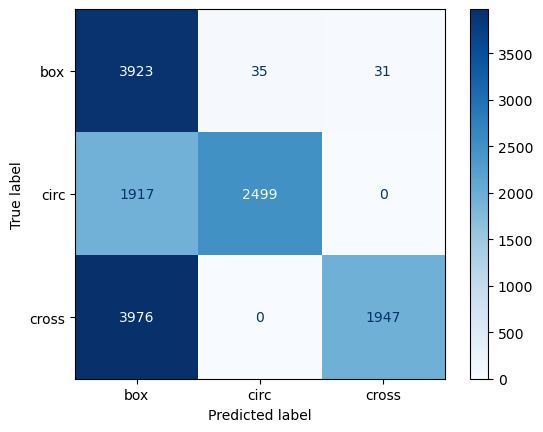

In [15]:
## Calcular la precisión y matriz de confusion
true_labels = [label for _, label, _, _ in predictions]
predicted_labels = [pred.split('_')[0] for _, _, pred, _ in predictions]
accuracy = accuracy_score(true_labels, predicted_labels)
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=["box", "circ", "cross"])

## Graficar la matriz de confusion.
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["box", "circ", "cross"])
disp.plot(cmap=plt.cm.Blues)
plt.show()

* Por ultimo se muestra el porcentaje de precisión calculado previamente.

In [16]:
print(f"Precisión: {accuracy:.2f}")

Precisión: 0.58


# 6. Medición
Recuerda que debes imprimir el tiempo que tarda tu algoritmo en procesar todas las imagenes en la base de datos. Usa el siguiente fragmento de código, ubicando el inicio y fin donde corresponda.

* Se muestra la cantidad de segundos que se demoro el proceso, aproximadamente unos 4 minutos.

In [18]:
print(f"Total processing time: {total_time:.2f} seconds")

Total processing time: 247.24 seconds
